### Part II :  (long version, generating simulated SEDs for all the galaxies)

(1) Read in the master catalog (a SNANA HOSTLIB file) generated in Part I 

(2) For each simulated SN host galaxy, use the EAZY code to make a simulated host galaxy spectrum (from the best-fitting photoz template)

(3) DOABLE, BUT NOT YET DONE: Store each simulated spectrum as an ascii .dat file with wavelength in nm and AB mag (suitable for input to the Subaru ETC).

(4) STILL TBD :  Store the revised master catalog (now updated with SED .dat file names) as a modified SNANA HOSTLIB file (ascii text)

* NOTE: At the moment, I'm working with a shortened library of galaxies, containing just 29 galaxies from the COSMOS field, selected because we think we have decent real-world DEIMOS spectra to compare to. (from the COSMOS DEIMOS paper by Gunther Hasinger, with data available here: 
https://irsa.ipac.caltech.edu/data/COSMOS/spectra/deimos/deimos.html)

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
from astropy.io import fits
from glob import glob
from importlib import reload
from matplotlib import pyplot as plt

from astropy.table import Table, Column
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM

import sncosmo
import snhostspec

from scipy.interpolate import interp1d
from scipy.integrate import trapz

In [3]:
reload(snhostspec)

<module 'snhostspec' from '/Users/rodney/Dropbox/src/wfirst/snhostspec.py'>

In [4]:
medsmooth = lambda f,N : np.array( [ np.median( f[max(0,i-N):min(len(f),max(0,i-N)+2*N)]) for i in range(len(f)) ] )

In [5]:
flcdm = FlatLambdaCDM(H0=73, Om0=0.27)

In [38]:
def scale_to_match_imag(wave, flam, imag, medsmooth_window=20, 
                        showplot=False, ax=None):
    """KLUDGE!!  Using sncosmo to make this galaxy SED into a Source so 
    we can integrate into mags using the sncosmo bandmag, and rescale 
    to match a pre-defined mag
    
    wave: wavelength in angstroms
    flam: flambda in erg/s/cm2/A
    imag: sdss i band magnitude to scale to
    """    
    # check that we cover the i band
    if wave[0]>6600:
        wave = np.append([6580], wave)
        flam = np.append([1e-20], flam)
    if wave[-1]<8380:
        wave = np.append(wave, [8400])
        flam = np.append(flam, [1e-20])
    
    # Make a dummy sncosmo Source and scale it to the given sdss i band mag
    phase = np.array([-1, 0, 1, 2]) # need at least 4 phase positions for a source
    flam_med = medsmooth(flam, medsmooth_window)
    flux = np.array([flam_med, flam_med, flam_med, flam_med]) # Use the median-smoothed version
    galsource = sncosmo.TimeSeriesSource(phase, wave, flux)    
    galsource.set_peakmag(imag, 'sdssi', 'ab')

    fout = galsource.flux(0,wave)
    
    if showplot:
        if ax is None:
            ax = plt.gca()

            ax.plot(wave, fout)
            ax.set_xlim(4800,10400)
            #ax.set_ylim(-10,80)
            ax.set_xlabel('wavelength ($\AA$)')
            ax.set_ylabel('f$_\lambda$ (erg/s/cm2/A)')

            # For this galaxy, the scaling factor that makes the spectrum match the i band mag
            scale_factor = np.median(flam_med / galsource.flux(0, wavelength))
            ax.text(0.05,0.9, "scale to match i mag = {:.1f}".format(scale_factor), 
                    ha='left', va='top', transform=ax.transAxes)

    return(wave, fout)


# (1) Read in the master catalog and load the EAZY SED template data

In [39]:
sim1 = snhostspec.SnanaSimData()
sim1.load_hostlib_catalog("DATA/cosmos_example_hostlib.txt")
sim1.load_eazypy_templates("DATA/eazy_13_spectral_templates.dat")

Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat


# (2) Make simulated SEDs from the EAZY coefficients + templates.  Make a summary plot with all 29.

In [40]:
def mAB_from_flambda(flambda, wave):
    """ Convert from flux density f_lambda in erg/s/cm2/A 
    into AB mag
    
    flambda: flux density f_lambda (erg/s/cm2/A)
    wave : wavelength in angstroms
    
    (see https://en.wikipedia.org/wiki/AB_magnitude)
    """
    return(-2.5 * np.log10(3.34e4 * wave * wave * (flambda / 3631)))


def getdeimosdat(galid, medsmoothpix=20, returnfluxunit='AB', returnwaveunit='A', extension='fits',
                 imag=None):
    deimosfilename = "DATA/cosmos_example_spectra/cosmos_example_spec1d_{0}.{1}".format(galid, extension)
   
    if extension=='fits':
        deimosdat = Table.read(deimosfilename, format='fits')
        f = np.array(deimosdat['FLUX'][0])
        w = np.array(deimosdat['LAMBDA'][0])
        ivalid = np.where((-1000<f) & (f<100))[0]
    elif extension=='txt':
        deimosdat = Table.read(deimosfilename, format='ascii.commented_header', header_start=-1, data_start=0)
        f = np.array(deimosdat['flux'])
        w = np.array(deimosdat['wavelength'])
        ivalid = np.where((-100<f) & (f<100))[0]

    f = f[ivalid] * 1e-17 # erg/s/cm2/A
    w = w[ivalid] 

    if imag is not None:
        wsmooth, fsmooth = scale_to_match_imag(w, f, imag, medsmooth_window=medsmoothpix, showplot=False, ax=None)
        
    if returnfluxunit=='AB':
        f = mAB_from_flambda(f, w)
        fsmooth = mAB_from_flambda(fsmooth, wsmooth)
    if returnwaveunit=='nm':
        w = w / 10
        wsmooth = wsmooth/10
        
    inotnan = np.isfinite(f)
    fnotnan = f[inotnan]
    wnotnan = w[inotnan]  
    
    if imag is None:
        wsmooth = wnotnan
        fsmooth = medsmooth(fnotnan,medsmoothpix)

    return(wnotnan, fnotnan, wsmooth, fsmooth)


In [41]:
# read in the filter data, downloaded from http://svo2.cab.inta-csic.es/svo/theory//fps3/
# also available at: https:// wfirst.gsfc.nasa.gov/science/sdt_public/wps/references/ instrument/WFIRST-WFI-Transmission_160720.xlsm
J_hst = ascii.read("DATA/HST_WFC3_IR.F125W.dat")
H_hst = ascii.read("DATA/HST_WFC3_IR.F160W.dat")
J_wfirst = ascii.read("DATA/WFIRST_WFI.J129.dat")
H_wfirst = ascii.read("DATA/WFIRST_WFI.H158.dat")

def getJHmags(wave, flambda):
    """integrate over the J and H bandpasses and return an AB mag"""

In [42]:
# NOTE: This function uses the 'sim1' object created above.
def plot_spec_comparison(galid, medsmooth_window=20, rescaledeimos=True, ax=None):
    """Plot flux vs wavelength for the given galaxy ID, showing both the observed 
    DEIMOS spectrum and the Eazy-simulated spectrum. """
    if ax is None:
        fig = plt.figure(figsize=[12,4])
        ax = fig.add_subplot(1,1,1)

    # row index for this galaxy in the simdata table
    igal = np.where(sim1.simdata['GALID'] == galid)[0][0]

    # read in the mag data for the DEIMOS spectra
    deimoscat = ascii.read("DATA/cosmos_example_spectra/cosmos_example_spectra.txt", format='fixed_width')
    ideimoscat = np.where(deimoscat['GALID']==galid)[0]
    imag = deimoscat['imag'][ideimoscat]
    kmag = deimoscat['kmag'][ideimoscat]   
    

    # read in the actual observed DEIMOS spectrum 
    if rescaledeimos:
        # rescale to match the observed SDSS i band mag
        wdeimos, mdeimos, wsmooth, mdeimos_smooth = getdeimosdat(
            galid, medsmooth_window, returnwaveunit='A', returnfluxunit='AB', 
            extension='fits', imag=imag)        
    else:
        # Use the observed DEIMOS spectrum without rescaling
        wdeimos, mdeimos, wsmooth, mdeimos_smooth = getdeimosdat(
            galid, medsmooth_window, returnwaveunit='A', returnfluxunit='AB', 
            extension='fits', imag=None)

    #import pdb; pdb.set_trace()
    #ax.plot(wdeimos, mdeimos, label='deimos', color='0.5', alpha=0.2)   
    ax.plot(wsmooth, mdeimos_smooth, label='smoothed', color='b')

    z = sim1.simdata['ZTRUE'][igal]   
    Jmag = sim1.simdata['hstj_obs'][igal]
    Hmag = sim1.simdata['hsth_obs'][igal]    

    # plot the iJHK mags
    ax.errorbar(7500, imag, xerr=500, marker='s', color='k', ms=8, zorder=1000)
    ax.errorbar(12500, Jmag, xerr=12500-11000,  marker='s', color='k', ms=8, zorder=1000)
    ax.errorbar(16000, Hmag, xerr=16000-13900,  marker='s', color='k', ms=8, zorder=1000)
    ax.errorbar(20000, kmag, xerr=2100,  marker='s', color='k', ms=8, zorder=1000)
    
    # plot the EAZY simulated spectrum
    eazycoeffs = np.array([sim1.simdata[col][igal] for col in sim1.simdata.colnames if col.startswith('eazy_coeff')])
    outfilename = "DATA/cosmos_example_spectra/cosmos_example_host_simspec_{:6d}.fits".format(galid)
    wobs, fobs = snhostspec.simulate_eazy_sed_from_coeffs(
        eazycoeffs, sim1.eazytemplatedata, z, returnwaveunit='A', returnfluxunit='AB',
        savetofile=outfilename, overwrite=True)
    ax.plot(wobs, fobs, label=igal, color='g', zorder=100)
    
    ax.set_xlim(4500,23000)
    #ax.set_ylim(-0.25*1e-16,0.3*1e-16)
    #ax.set_ylim(27, 20)
    ax.text(0.95,0.95, galid, ha='right', va='top', transform=ax.transAxes)
    ax.text(0.95,0.88, "z={0}".format(z), ha='right', va='top', transform=ax.transAxes)

    ax.invert_yaxis()
    plt.tight_layout()
    #plt.savefig("cosmos_example_spec_eazysims.pdf")

    return(mdeimos_smooth)

/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


(26, 22)

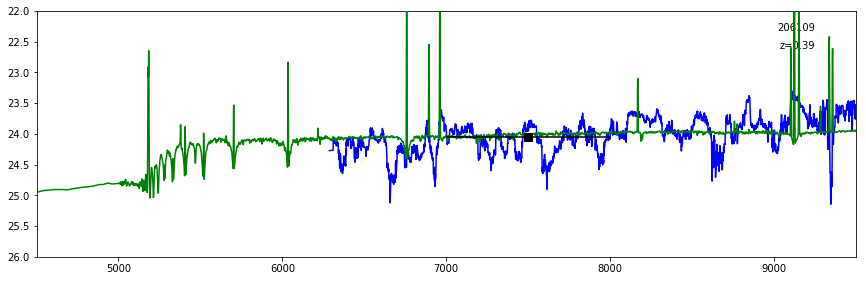

In [37]:
fds = plot_spec_comparison(206109, rescaledeimos=True, medsmooth_window=50)
ax = plt.gca()
ax.set_xlim(4500, 9500)
ax.set_ylim(26,22)

/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


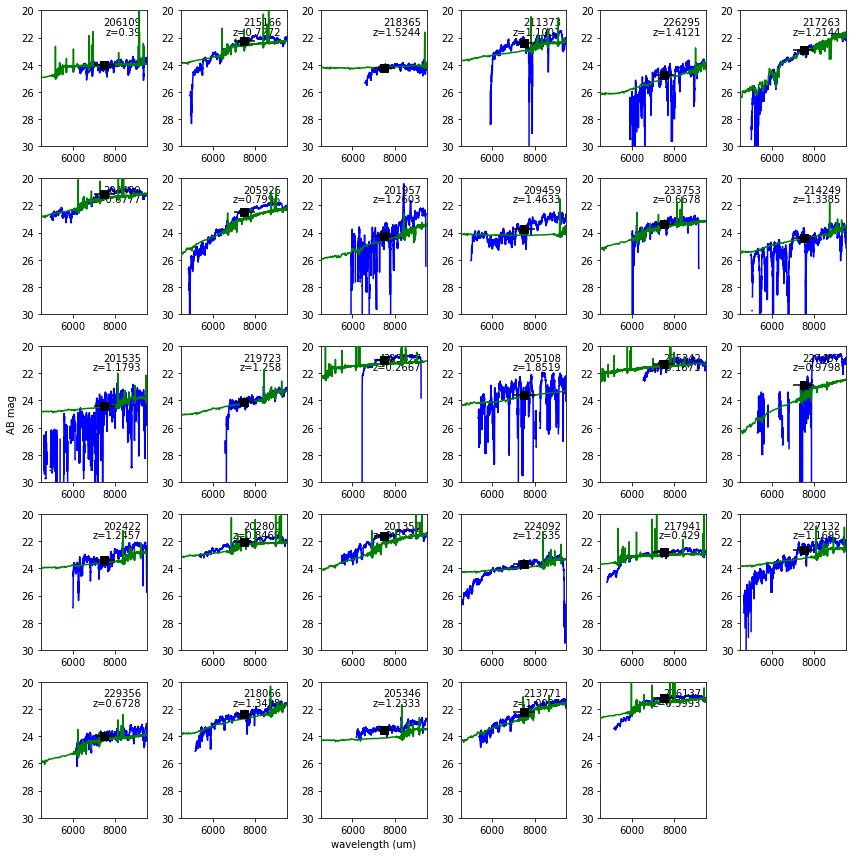

In [44]:
fig = plt.figure(figsize=[12,12])
#fig = plt.figure(figsize=[12,4])
for igal in range(len(sim1.simdata)):
    galid = sim1.simdata['GALID'][igal]
    ax = fig.add_subplot(5,6,igal+1)
    #ax = fig.add_subplot(1,4,igal+1)
    plot_spec_comparison(galid, ax=ax, rescaledeimos=True, medsmooth_window=50)
    
    ax.set_xlim(4500, 9500)
    ax.set_ylim(30,20)
    
    if igal ==12:
        ax.set_ylabel("AB mag")
    if igal == 26:
        ax.set_xlabel("wavelength (um)")
plt.tight_layout()
plt.savefig("cosmos_example_spec_eazysims.pdf")